In [1]:
import os
import pandas as pd
import numpy as np
import joblib
from sklearn.preprocessing import StandardScaler
from src.data_preparation import *
from src.trainers import *
from src.testing import *
import warnings
from hydra import initialize, compose
from omegaconf import OmegaConf

warnings.filterwarnings("ignore", message=".*use_label_encoder.*")
with initialize(version_base=None, config_path="configs"):
    cfg = compose(config_name="default")

Data from all unauthorized users was used as validation data. The only difference from authorized users is that the data is normalized relative to the StandardScaler object created for the training data.

In [ ]:
all_users = cfg.all_users
main_user = cfg.main_user
scaler_path = cfg.paths.scaler
ohe_path = cfg.paths.one_hot_encoding

try:
    all_users.remove(main_user)
except ValueError:
    pass
all_users.insert(0, main_user)

raw_by_user = {}
all_action_types = set()

for user_id in all_users:
    ds_dir = os.path.join(cfg.paths.raw_data_root, "training_files", f"user{user_id}")
    df_raw = extract_features_from_dir(ds_dir, attach_filename=False)
    if df_raw.empty:
        print(f"No data for user{user_id}.")
        continue
    print(f"Extracted data for user{user_id}")
    raw_by_user[user_id] = df_raw
    all_action_types.update(df_raw['action_type'].dropna().unique().tolist())

if not raw_by_user:
    raise RuntimeError("No training/validation data.")

# Define constant OHE columns
ohe_cols = [f"action_type_{cat}" for cat in sorted(all_action_types)]
joblib.dump(ohe_cols, ohe_path)

# Fit scalera on main user
main_df_raw = raw_by_user.get(main_user)
if main_df_raw is None or main_df_raw.empty:
    raise RuntimeError("No main user data for Scaler.")

scaler = StandardScaler()
main_numeric = split_numeric(main_df_raw)
scaler.fit(main_numeric)
joblib.dump(scaler, scaler_path)

# Transform + OHE + save per user
for user_id, df_raw in raw_by_user.items():
    df_numeric = split_numeric(df_raw)
    X_scaled = pd.DataFrame(
        scaler.transform(df_numeric),
        columns=df_numeric.columns,
        index=df_numeric.index
    )
    X_ohe = ensure_ohe(df_raw['action_type'], ohe_cols)
    df_final = pd.concat([X_scaled, X_ohe], axis=1)
    joblib.dump(df_final, f"{cfg.paths.preprocessed_data}/df_user{user_id}.pkl")
    print(f"Saved df_user{user_id}.pkl  rows={len(df_final)}")

The test data is enriched with file index information and whether the session was authorized or not. The file indexes are important because the tests verified whether entire actions were authorized, as defined in the public_labels.csv file.

In [ ]:
csv_path = os.path.join(cfg.paths.raw_data_root, "public_labels.csv")
main_user = cfg.main_user
test_dir = os.path.join(cfg.paths.raw_data_root, "test_files")
scaler = joblib.load(cfg.paths.scaler)
ohe_cols = joblib.load(cfg.paths.one_hot_encoding)

labels = pd.read_csv(csv_path)
label_map = dict(zip(labels['filename'].astype(str), labels['is_illegal']))

df_test_raw = extract_features_from_dir(os.path.join(test_dir, f"user{main_user}"), attach_filename=True)
if df_test_raw.empty:
    raise RuntimeError(f"No test data in {test_dir}.")

df_test_raw['is_illegal'] = df_test_raw['__filename'].map(lambda x: label_map.get(str(x), None))
df_test_raw = df_test_raw[~df_test_raw['is_illegal'].isna()]

if df_test_raw.empty:
    raise RuntimeError("No matching labels for test files.")

test_numeric = split_numeric(df_test_raw, extra_drop_cols=['is_illegal', 'file_id', '__filename'])
X_test_scaled = pd.DataFrame(
    scaler.transform(test_numeric),
    columns=test_numeric.columns,
    index=test_numeric.index
)

X_test_ohe = ensure_ohe(df_test_raw['action_type'], ohe_cols)

df_test_final = pd.concat(
    [X_test_scaled, X_test_ohe, df_test_raw[['is_illegal', 'file_id']]],
    axis=1
)

joblib.dump(df_test_final, os.path.join(cfg.paths.preprocessed_data, f"df_user{main_user}_test.pkl"))
print(f"Saved df_user{main_user}_test.pkl  (rows={len(df_test_final)})")

## TRAINING

In [2]:
legal_df = joblib.load(os.path.join(cfg.paths.preprocessed_data, f'df_user{cfg.main_user}.pkl'))
illegal_users = list(cfg.all_users)
illegal_users.remove(cfg.main_user)
illegal_df = pd.concat([joblib.load(os.path.join(cfg.paths.preprocessed_data, f"df_user{id}.pkl")) for id in illegal_users], ignore_index=True)

numeric_cols = [c for c in legal_df.columns if np.issubdtype(legal_df[c].dtype, np.number)]
categorical_cols = [c for c in legal_df.columns if c not in numeric_cols]

## Unsupervised

###  K-means trainer

In [ ]:
km_trainer = KMeansTrainer(
    legal_df,
    results_path=cfg.paths.K_means.all_results,
    cv_number=cfg.cv_number,
    numeric_cols=numeric_cols,
    categorical_cols=[],
)
best_score_km, best_params_km, best_model_km, best_pca_km = km_trainer.custom_grid_search(
    OmegaConf.to_container(cfg.K_means.param_grid, resolve=True)
)
save_results(
    "KMeans",
    best_params_km, best_model_km, best_pca_km,
    cfg.paths.K_means.best_results,
    cfg.paths.K_means.model,
    cfg.paths.K_means.preproc,
)

###  Isolation Forest Trainer

In [ ]:
if_trainer = IFTrainer(
    legal_df,
    results_path=cfg.paths.Isolation_forest.all_results,
    cv_number=cfg.cv_number,
    numeric_cols=numeric_cols,
    categorical_cols=categorical_cols,
)
best_score_if, best_params_if, best_model_if, best_preproc_if = if_trainer.custom_grid_search(
    OmegaConf.to_container(cfg.Isolation_forest.param_grid, resolve=True)
)
save_results(
    "IsolationForest",
    best_params_if, best_model_if, best_preproc_if,
    cfg.paths.Isolation_forest.best_results,
    cfg.paths.Isolation_forest.model,
    cfg.paths.Isolation_forest.preproc,
)

##  Supervised

In [4]:
legal_df_sup = legal_df.copy();   legal_df_sup["label"] = 0
illegal_df_sup = illegal_df.copy(); illegal_df_sup["label"] = 1
X_sup = pd.concat([legal_df_sup, illegal_df_sup], ignore_index=True)
y_sup = X_sup["label"]; X_sup = X_sup.drop(columns=["label"])

###  XGBoost Trainer

In [ ]:
xgb_trainer = XGBoostTrainer(
    X_sup, y_sup,
    results_path=cfg.paths.XGBoost.all_results,
    cv_number=cfg.cv_number,
    numeric_cols=numeric_cols,
    categorical_cols=categorical_cols,
)
best_score, best_params, best_model, best_preproc = xgb_trainer.custom_grid_search(
    OmegaConf.to_container(cfg.XGBoost.param_grid, resolve=True)
)
save_results(
    "XGBoost",
    best_params, best_model, best_preproc,
    cfg.paths.XGBoost.best_results,
    cfg.paths.XGBoost.model,
    cfg.paths.XGBoost.preproc,
)

###  SVM Trainer

In [ ]:
svm_trainer = SVMTrainer(
    X_sup, y_sup,
    results_path=cfg.paths.SVM.all_results,
    cv_number=cfg.cv_number,
    numeric_cols=numeric_cols,
    categorical_cols=[],
)
best_score_svm, best_params_svm, best_model_svm, best_pca_svm = svm_trainer.custom_grid_search(
    OmegaConf.to_container(cfg.SVM.param_grid, resolve=True)
)
save_results(
    "SVM",
    best_params_svm, best_model_svm, best_pca_svm,
    cfg.paths.SVM.best_results,
    cfg.paths.SVM.model,
    cfg.paths.SVM.preproc,
)

##  TESTING

In [20]:
df = joblib.load(os.path.join(cfg.paths.preprocessed_data, f'df_user{cfg.main_user}_test.pkl'))

numeric_cols = [c for c in df.columns if np.issubdtype(df[c].dtype, np.number) and c not in ['is_illegal', 'file_id']]
categorical_cols = [c for c in df.columns if c not in numeric_cols + ['is_illegal', 'file_id']]

df_numeric = df[numeric_cols]
df_categorical = df[categorical_cols]

is_illegal = df['is_illegal'].T
file_id = df['file_id']

###  K-means

In [ ]:
estimator, preprocessed_data = read_model_preprocess_data(
    cfg.paths.K_means.model, 
    cfg.paths.K_means.preproc,
    df_numeric)

distances = estimator.transform(preprocessed_data)
scores = np.min(distances, axis=1)
scores = scores.transpose()

visualize_results(scores, file_id, is_illegal)

In [ ]:
estimator, preprocessed_data = read_model_preprocess_data(
    cfg.paths.K_means.model,
    cfg.paths.K_means.preproc,
    df_numeric)

distances = estimator.transform(preprocessed_data)
fpr, tpr, thresholds_roc, roc_auc, precision, recall, pr_auc = validate_per_action(scores, is_illegal)

plot(fpr, tpr, roc_auc, recall, precision, pr_auc, thresholds_roc)

###  Las Izolacyjny

In [ ]:
estimator, preprocessed_data = read_model_preprocess_data(
    cfg.paths.Isolation_forest.model, 
    cfg.paths.Isolation_forest.preproc,
    df_numeric)

preprocessed_data = np.concatenate([preprocessed_data, df_categorical.to_numpy()], axis=1)
scores = estimator.decision_function(preprocessed_data)
scores = - scores

visualize_results(scores, file_id, is_illegal)

### XGBoost

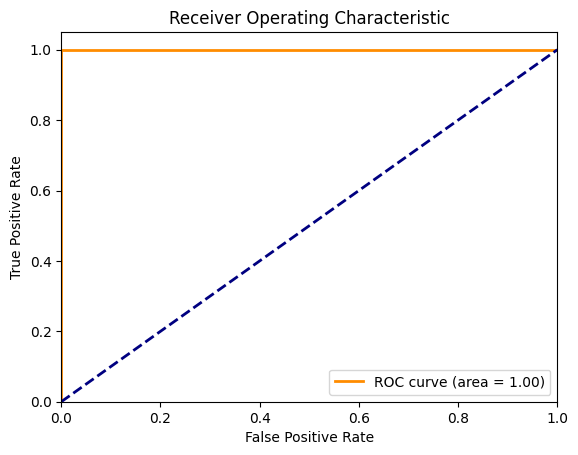

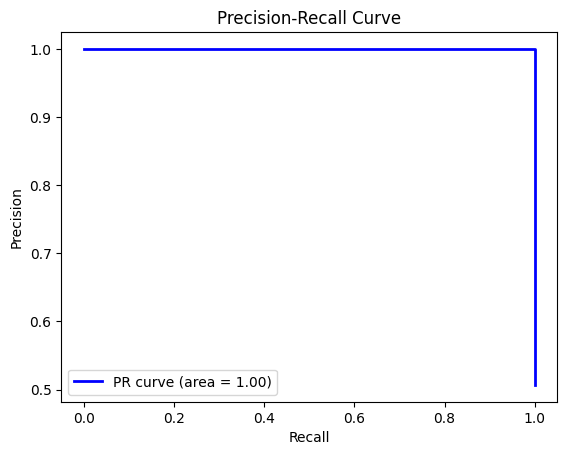

auc:  1.0
pr auc:  1.0
acc:  [0.4931506849315068, 0.5068493150684932, 1.0, 0.5068493150684932]
recalls:  [0.0, 0.02702702702702703, 1.0, 1.0]


In [ ]:
estimator, preprocessed_data = read_model_preprocess_data(
    cfg.paths.XGBoost.model, 
    cfg.paths.XGBoost.preproc,
    df_numeric)

preprocessed_data = np.concatenate([preprocessed_data, df_categorical.to_numpy()], axis=1)
scores = estimator.predict_proba(preprocessed_data[:, ])[:, 1]
visualize_results(scores, file_id, is_illegal)

In [ ]:
estimator, preprocessed_data = read_model_preprocess_data(
    cfg.paths.XGBoost.model, 
    cfg.paths.XGBoost.preproc,
    df_numeric)

preprocessed_data = np.concatenate([preprocessed_data, df_categorical.to_numpy()], axis=1)
scores = estimator.predict_proba(preprocessed_data)[:, 1]
fpr, tpr, thresholds_roc, roc_auc, precision, recall, pr_auc = validate_per_action(scores, is_illegal)

plot(fpr, tpr, roc_auc, recall, precision, pr_auc, thresholds_roc)

###  SVM

In [ ]:
estimator, preprocessed_data = read_model_preprocess_data(
    cfg.paths.SVM.model, 
    cfg.paths.SVM.preproc,
    df_numeric)

scores = estimator.decision_function(preprocessed_data)
visualize_results(scores, file_id, is_illegal)

In [ ]:
estimator, preprocessed_data = read_model_preprocess_data(
    cfg.paths.SVM.model, 
    cfg.paths.SVM.preproc,
    df_numeric)

scores = estimator.decision_function(preprocessed_data)
fpr, tpr, thresholds_roc, roc_auc, precision, recall, pr_auc = validate_per_action(scores, is_illegal)
plot(fpr, tpr, roc_auc, recall, precision, pr_auc, thresholds_roc)

## Wnioski
- Analiza PCA ograniczająca liczbę wymiarów poprawiła skuteczność każdego testowanego modelu, szczególnie dla algorytmów uczenia nienadzorowanego, gdzie dla kolejno K-means i IsolationTree najlepsze wyniki uzyskanko dla, kolejno: 11 i 17 komponentów, co oznacza znaczną redukcję wymiarów. Efekt ten może wynikać z odszumiania, które jest wynikiem wykorzystania algorytmu PCA.
- Dla algorytmu K-means wybrana metryka polegająca na określeniu progowej odległości od wyznaczonych klastrów daja satysfakcjonujące wyniki. W przypadku badania uzyskano lepsze wyniki dla tej strategii niż przy algorytmie Drzew Izolacyjnych.
- Dla algorytmu K-means normalizacja wielkością klastrów znacznie poprawiła wyniki, co można zauważyć w pliku 'k-means_results'.
- Dla algorytmu K-means wyznaczenie wielu klastrów może poprawić wyniki, co może odpowiadać określeniu kilku klas akcji autoryzowanych.
- Dla algorytmu SVM wprowadzenie nieliniowości za pomocą funkcji jądra może poprawić wyniki klasyfikacji.
- Najlepsze wyniki uzyskano dla wszystkich klasyfikacji uczenia nazdorowanego, w szczególności XGBoost.
- W obu przypadkach uczenia nazdorowanego najlepiej poradziły sobie modele wykorzystujące wzbogacanie zbioru treningowego za pomocą algorytmu 'SMOTE'.